In [ ]:

"""
This module defines a function to create a state graph for an agent-based workflow and compile it into a runnable workflow.
Functions:
    create_graph(server=None, model=None, stop=None, model_endpoint=None, temperature=0):
        Creates a StateGraph with various agents and tools as nodes, and defines the edges between them.
        Parameters:
            server (optional): The server to be used by the agents.
            model (optional): The model to be used by the agents.
            stop (optional): The stop condition for the agents.
            model_endpoint (optional): The endpoint for the model.
            temperature (optional): The temperature setting for the model.
        Returns:
            StateGraph: The constructed state graph with nodes and edges.
    compile_workflow(graph):
        Compiles the given state graph into a runnable workflow.
        Parameters:
            graph (StateGraph): The state graph to be compiled.
        Returns:
            The compiled workflow.
"""
import json
import ast
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage
from models.openai_models import get_open_ai_json
from langgraph.checkpoint.sqlite import SqliteSaver
from agents.agents import (
    PlannerAgent,
    SelectorAgent,
    ReporterAgent,
    ReviewerAgent,
    RouterAgent,
    FinalReportAgent,
    EndNodeAgent
)
from prompts.prompts import (
    reviewer_prompt_template, 
    planner_prompt_template, 
    selector_prompt_template, 
    reporter_prompt_template,
    router_prompt_template,
    reviewer_guided_json,
    selector_guided_json,
    planner_guided_json,
    router_guided_json

)
from tools.google_serper import get_google_serper
from tools.basic_scraper import scrape_website
from states.state import AgentGraphState, get_agent_graph_state, state

def create_graph(server=None, model=None, stop=None, model_endpoint=None, temperature=0):
    graph = StateGraph(AgentGraphState)

    graph.add_node(
        "planner", 
        lambda state: PlannerAgent(
            state=state,
            model=model,
            server=server,
            guided_json=planner_guided_json,
            stop=stop,
            model_endpoint=model_endpoint,
            temperature=temperature
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(state=state, state_key="reviewer_latest"),
            # previous_plans=lambda: get_agent_graph_state(state=state, state_key="planner_all"),
            prompt=planner_prompt_template
        )
    )

    graph.add_node(
        "selector",
        lambda state: SelectorAgent(
            state=state,
            model=model,
            server=server,
            guided_json=selector_guided_json,
            stop=stop,
            model_endpoint=model_endpoint,
            temperature=temperature
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(state=state, state_key="reviewer_latest"),
            previous_selections=lambda: get_agent_graph_state(state=state, state_key="selector_all"),
            serp=lambda: get_agent_graph_state(state=state, state_key="serper_latest"),
            prompt=selector_prompt_template,
        )
    )

    graph.add_node(
        "reporter", 
        lambda state: ReporterAgent(
            state=state,
            model=model,
            server=server,
            stop=stop,
            model_endpoint=model_endpoint,
            temperature=temperature
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(state=state, state_key="reviewer_latest"),
            previous_reports=lambda: get_agent_graph_state(state=state, state_key="reporter_all"),
            research=lambda: get_agent_graph_state(state=state, state_key="scraper_latest"),
            prompt=reporter_prompt_template
        )
    )

    graph.add_node(
        "reviewer", 
        lambda state: ReviewerAgent(
            state=state,
            model=model,
            server=server,
            guided_json=reviewer_guided_json,
            stop=stop,
            model_endpoint=model_endpoint,
            temperature=temperature
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(state=state, state_key="reviewer_all"),
            # planner=lambda: get_agent_graph_state(state=state, state_key="planner_latest"),
            # selector=lambda: get_agent_graph_state(state=state, state_key="selector_latest"),
            reporter=lambda: get_agent_graph_state(state=state, state_key="reporter_latest"),
            # planner_agent=planner_prompt_template,
            # selector_agent=selector_prompt_template,
            # reporter_agent=reporter_prompt_template,
            # serp=lambda: get_agent_graph_state(state=state, state_key="serper_latest"),
            prompt=reviewer_prompt_template
        )
    )

    graph.add_node(
        "router", 
        lambda state: RouterAgent(
            state=state,
            model=model,
            server=server,
            guided_json=router_guided_json,
            stop=stop,
            model_endpoint=model_endpoint,
            temperature=temperature
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(state=state, state_key="reviewer_all"),
            # planner=lambda: get_agent_graph_state(state=state, state_key="planner_latest"),
            # selector=lambda: get_agent_graph_state(state=state, state_key="selector_latest"),
            # reporter=lambda: get_agent_graph_state(state=state, state_key="reporter_latest"),
            # planner_agent=planner_prompt_template,
            # selector_agent=selector_prompt_template,
            # reporter_agent=reporter_prompt_template,
            # serp=lambda: get_agent_graph_state(state=state, state_key="serper_latest"),
            prompt=router_prompt_template
        )
    )


    graph.add_node(
        "serper_tool",
        lambda state: get_google_serper(
            state=state,
            plan=lambda: get_agent_graph_state(state=state, state_key="planner_latest")
        )
    )

    graph.add_node(
        "scraper_tool",
        lambda state: scrape_website(
            state=state,
            research=lambda: get_agent_graph_state(state=state, state_key="selector_latest")
        )
    )

    graph.add_node(
        "final_report", 
        lambda state: FinalReportAgent(
            state=state
        ).invoke(
            final_response=lambda: get_agent_graph_state(state=state, state_key="reporter_latest")
        )
    )

    graph.add_node("end", lambda state: EndNodeAgent(state).invoke())

    # Define the edges in the agent graph
    def pass_review(state: AgentGraphState):
        review_list = state["router_response"]
        if review_list:
            review = review_list[-1]
        else:
            review = "No review"

        if review != "No review":
            if isinstance(review, HumanMessage):
                review_content = review.content
            else:
                review_content = review
            
            review_data = json.loads(review_content)
            next_agent = review_data["next_agent"]
        else:
            next_agent = "end"

        return next_agent

    # Add edges to the graph
    graph.set_entry_point("planner")
    graph.set_finish_point("end")
    graph.add_edge("planner", "serper_tool")
    graph.add_edge("serper_tool", "selector")
    graph.add_edge("selector", "scraper_tool")
    graph.add_edge("scraper_tool", "reporter")
    graph.add_edge("reporter", "reviewer")
    graph.add_edge("reviewer", "router")

    graph.add_conditional_edges(
        "router",
        lambda state: pass_review(state=state),
    )

    graph.add_edge("final_report", "end")

    return graph

def compile_workflow(graph):
    workflow = graph.compile()
    return workflow

In [1]:
from typing import Annotated # used for type hinting with metadata
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults # used for search tool
from langchain_community.tools.google_search import GoogleSearchResults # used for search tool
from langchain_core.messages import BaseMessage 
from typing_extensions import TypedDict
# from langchain_community.tools.web_scraper import WebScraperResults # used for web scraping tool
# from langchain_community.tools.

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [4]:
class State(TypedDict):
    '''State for the state graph'''
    messages: Annotated[list, add_messages]

# Create the state graph 
graph_builder = StateGraph(State)


# tool = TavilySearchResults(max_results=2)
tool = GoogleSearchResults(max_results=2) # search tool
tools = [tool]
llm =  ChatOpenAI(model="4o")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

ValidationError: 1 validation error for GoogleSearchResults
api_wrapper
  Field required [type=missing, input_value={'max_results': 2}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

# Langgraph test

In [4]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key
# print(openai_api_key)

In [5]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

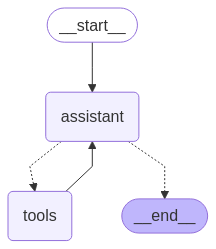

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant) # assistant is a node that uses the assistant function
builder.add_node("tools", ToolNode(tools)) # tools is a node that uses the ToolNode class with the tools list

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="process for given list [{operation:'take 2 and 3 add it and multiply its result with 5'},{operation:'take 4 and 6 add it and multiply its result with 10'},{operation:'take 121 and 3 add it and divide its result with 2'}]. I want the result in the form of list of dictionary")]
messages = react_graph.invoke({"messages": messages})

In [15]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

process for given list [{operation:'take 2 and 3 add it and multiply its result with 5'},{operation:'take 4 and 6 add it and multiply its result with 10'},{operation:'take 121 and 3 add it and divide its result with 2'}]. I want the result in the form of list of dictionary
================================== Ai Message ==================================
Tool Calls:
  add (call_quCADuLcciHG6saajb7VAprD)
 Call ID: call_quCADuLcciHG6saajb7VAprD
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3FV4lkU0QXDhuRCBz4OLoJf1)
 Call ID: call_3FV4lkU0QXDhuRCBz4OLoJf1
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: multiply

25
================================== Ai Message =====

# Design websearch and scrapping tool

In [18]:
!pip install googlesearch-python

In [2]:
from googlesearch import search
result = search("Google", advanced=True)

In [3]:
for i in result:
    print(i.url)

https://www.google.co.in/
https://www.google.com/
https://twitter.com/Google?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
https://www.google.co.in/
https://about.google/
https://cloud.google.com/
https://search.google.com/search-console/about
https://play.google.com/store/apps/details?id=com.google.android.googlequicksearchbox&hl=en_IN
https://www.google.com/account/about/
https://myactivity.google.com/


In [ ]:
import os

os.path.abspath('.')
llm = ChatOpenAI(model="gpt-4o")


In [8]:
print(llm.invoke(f"Extract the topic only from given query. Query: 'write a blog on hcl technologies.'").content)

"HCL Technologies"


In [7]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="llama3.2")


In [15]:
from openai import OpenAI
import sys
sys.path.insert(0, '..')


class GenAI:
    def __init__(self):
        self.client = OpenAI(
        base_url = 'http://localhost:11434/v1',
        api_key='ollama', # required, but unused
        )


    def blog_generate(self, topic, context):
        ''' 
        It generates a blog post based on the given topic and context based on the tone
        '''
        completion = self.client.chat.completions.create(
        model="llama3.2",
        messages=[
            {"role": "system", "content": """
You are an AI assistant. Your task is to generate a detailed blog post in simplified language. 
The blog should be easy to understand, engaging, and informative. 
Make sure to break down complex concepts into simpler terms and provide examples where necessary.
"""},
            {
                "role": "user",
                "content": """
Write a blog post on the topic: {topic}. 

Context: {context}

Make sure the blog post is detailed, easy to understand, and engaging. Break down complex concepts into simpler terms and provide examples where necessary. 
""".format(topic=topic, context=context),
            }
            ],
        )
        return completion.choices[0].message.content
    
    

In [11]:
from langchain_openai import ChatOpenAI
import sys,os
# sys.path.insert(0, os.path.abspath('./src'),"..")
# from src.modules.genai import GenAI
from googlesearch import search
import requests
from bs4 import BeautifulSoup
import re

def validate_url(url: str) -> bool:
    """Validate the url.

    Args:
        url: The website url.
    """
    # Regular expression for validating a URL
    regex = re.compile(
        r'^(?:http|ftp)s?://'  # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'  # domain...
        r'localhost|'  # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}|'  # ...or ipv4
        r'\[?[A-F0-9]*:[A-F0-9:]+\]?)'  # ...or ipv6
        r'(?::\d+)?'  # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)

    if re.match(regex, url) is not None:
        return True
    else:
        return False


def web_search(topic: str) -> list:
    """Search the web for the query.

    Args:
        query: The search query.
    """
    results = search(topic, advanced=True)
    return [url.url for url in results if validate_url(url.url)][:2]

def query_title(query: str) -> str:
    """Query the title for the query.

    Args:
        query: The search query.
    """
    return llm.invoke(f"Extract the topic only from given query. Query: {query}.").content

def web_scrape(url: str) -> str:
    """Scrape the website for the url.

    Args:
        url: The website url.
    """
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html5lib') # html5lib parser is used to parse the content
    # print(soup.prettify())
    # print(soup.get_text())
    return soup.get_text()

def content_summary (content: str) -> str:
    """Generate a summary of the websearch.

    Args:
        content: Content of websearch.
    """
    return llm.invoke(f"Summarize the content in detail. Content: {content}").content
    
def generate_blog(query: str) -> str:
    """Generate a blog with the title and content if the query is not 

    Args:
        query: Unknown input query for websearch .
    """
    detailed_scrape_summary = ""
    topic = query_title(query)
    print("Topic-->",topic)
    url_list = web_search(topic)
    for url in url_list:
        print("URL-->",url)  
        content = web_scrape(url)
        content = content_summary(content)
        if content:
            detailed_scrape_summary += f"{content}\n\n"
    # print(detailed_scrape_summary)
    obj = GenAI()
    
    return obj.blog_generate(topic = topic, context = detailed_scrape_summary)


tools = [generate_blog]
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatOllama(model="llama3.2")


# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [12]:
url_list = web_search("Latest updates on HCL Technologies.")
print(url_list)

['https://economictimes.indiatimes.com/hcl-technologies-ltd/stocksupdate/companyid-4291.cms', 'https://www.hcltech.com/newsfeed']


In [16]:
query = "write a blog on latest agentic ai frameworks."
blog = generate_blog(query)

Topic--> Latest Agentic AI Frameworks
URL--> https://lekha-bhan88.medium.com/top-5-agentic-ai-frameworks-to-watch-in-2025-9d51b2b652c0
URL--> https://www.ibm.com/think/insights/top-ai-agent-frameworks


In [17]:
print(blog)

**Latest Agentic AI Frameworks: A Guide for Businesses**

Artificial intelligence (AI) has become an integral part of modern businesses, transforming the way they operate and interact with customers. Among the numerous AI frameworks available, agentic AI frameworks have emerged as a popular choice for organizations looking to create intelligent systems that can adapt and learn from their environment. In this blog post, we'll explore the latest agantic AI frameworks, their features, and benefits, along with example use cases.

**What are Agantic AI Frameworks?**

Agantic AI frameworks are designed to enable businesses to build intelligent systems that can learn and adapt in a data-driven world. These frameworks combine elements of both machine learning and ontology-based reasoning to create sophisticated models that can navigate complex decision-making spaces. Unlike traditional rule-based approaches, agentic AI frameworks use algorithms that allow their underlying logic to evolve over 

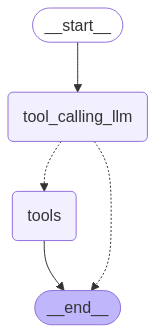

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
SYSTEM_PROMPT = """
You are an AI assistant. Your task is to generate a detailed blog post in simplified language. 
The blog must contains title, body and conclusion. It should be easy to understand, engaging, and informative. 
Make sure to break down complex concepts into simpler terms and provide examples where necessary.
"""
# System message
sys_msg = SystemMessage(content=SYSTEM_PROMPT)

# Node
def tool_calling_llm(state: MessagesState):
    # return {"messages": [llm_with_tools.invoke(state["messages"])]}
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([generate_blog]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# from langchain_core.messages import HumanMessage
# messages = [HumanMessage(content="Agentic AI")]
# messages = graph.invoke({"messages": messages})
# for m in messages['messages']:
#     m.pretty_print()

In [82]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Artifical Intelligence.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Artifical Intelligence.
================================== Ai Message ==================================

**Title: Understanding Artificial Intelligence: A Simple Guide**

**Body:**

Artificial Intelligence, or AI, is a buzzword you've likely heard a lot about. But what exactly is it? Let's break it down in a way that's easy to understand.

1. **What is AI?**

   AI is like teaching a computer to think and make decisions like a human. Imagine you have a smart friend who can learn from experience, solve problems, and even predict what might happen next. That's what AI does, but with computers.

2. **How Does AI Work?**

   AI uses something called algorithms, which are like step-by-step instructions, to analyze data and make decisions. Think of it like a recipe that a computer follows to bake a cake. But instead of baking, it might be deciding which movie you might like to watch based on your past choices.

In [72]:
print(messages['messages'][-1].content)

Artificial Intelligence (AI) is a fascinating and rapidly growing field that is changing the way we live and work. Let's break down what AI is, how it works, and some examples of how it's used today.

### What is Artificial Intelligence?

Artificial Intelligence refers to computer systems designed to perform tasks that normally require human intelligence. These tasks include understanding language, recognizing patterns, solving problems, and even learning from experience.

### How Does AI Work?

AI works by using algorithms, which are sets of rules or instructions given to a computer to help it solve problems or perform tasks. There are different types of AI, but two of the most common are:

1. **Machine Learning**: This is when computers learn from data. For example, if you show a computer many pictures of cats, it can learn to recognize a cat in new pictures.

2. **Deep Learning**: This is a type of machine learning that uses neural networks, which are computer systems modeled after 

In [2]:
%pip install -qU langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain_tavily import TavilySearch


In [2]:
import inspect


# retrieve the function's signature
sig = inspect.signature(TavilySearch)

print(sig)

# Access specific parameter details
for param in sig.parameters.values():
    print(f"Parameter: {param.name}")
    print(f"Type: {param.annotation}")
    print(f"Default: {param.default}")
    print(f"Kind: {param.kind}")
    print("---")

(*, name: str = 'tavily_search', description: str = 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', args_schema: Type[pydantic.main.BaseModel] = <class 'langchain_tavily.tavily_search.TavilySearchInput'>, return_direct: bool = False, verbose: bool = False, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, callback_manager: Optional[langchain_core.callbacks.base.BaseCallbackManager] = None, tags: Optional[list[str]] = None, metadata: Optional[dict[str, Any]] = None, handle_tool_error: bool = True, handle_validation_error: Union[bool, str, Callable[[Union[pydantic_core._p